In [1]:
import numpy as np

from qiskit import Aer
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.opflow import *
from qiskit.utils import QuantumInstance

In [2]:
backend = Aer.get_backend("qasm_simulator")
shots = 10
quantum_instance = QuantumInstance(backend, shots=shots)

### Parameterized circuits

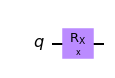

In [3]:
x = Parameter("x")

circuit = QuantumCircuit(1)
circuit.rx(x, 0)

circuit.draw("mpl")

In [4]:
circuit.parameters

ParameterView([Parameter(x)])

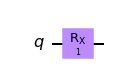

In [5]:
bound = circuit.bind_parameters([1])
bound.draw("mpl")

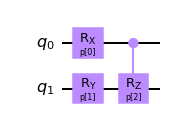

In [6]:
p = ParameterVector("p", 3)

circuit = QuantumCircuit(2)
circuit.rx(p[0], 0)
circuit.ry(p[1], 1)
circuit.crz(p[2], 0, 1)

circuit.draw("mpl")

In [7]:
circuit.parameters

ParameterView([ParameterVectorElement(p[0]), ParameterVectorElement(p[1]), ParameterVectorElement(p[2])])

### Executing circuits with Opflow

In [8]:
hamiltonian = (Z ^ Z) + (X ^ X)

In [9]:
sampler = CircuitSampler(quantum_instance)

In [10]:
bound = circuit.bind_parameters([1, 2, 3])
expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(bound))

print(expectation)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ
  + 1.0 * XX),
  CircuitStateFn(
       ┌───────┐         
  q_0: ┤ Rx(1) ├────■────
       ├───────┤┌───┴───┐
  q_1: ┤ Ry(2) ├┤ Rz(3) ├
       └───────┘└───────┘
  )
])


In [11]:
transformed = PauliExpectation().convert(expectation)
print(transformed)

SummedOp([
  ComposedOp([
    OperatorMeasurement(1.0 * ZZ),
    CircuitStateFn(
         ┌───────┐         
    q_0: ┤ Rx(1) ├────■────
         ├───────┤┌───┴───┐
    q_1: ┤ Ry(2) ├┤ Rz(3) ├
         └───────┘└───────┘
    )
  ]),
  ComposedOp([
    OperatorMeasurement(1.0 * ZZ),
    CircuitStateFn(
         ┌───────┐         ┌───┐
    q_0: ┤ Rx(1) ├────■────┤ H ├
         ├───────┤┌───┴───┐├───┤
    q_1: ┤ Ry(2) ├┤ Rz(3) ├┤ H ├
         └───────┘└───────┘└───┘
    )
  ])
])


In [12]:
sampled = sampler.convert(transformed)
print(sampled)

SummedOp([
  ComposedOp([
    OperatorMeasurement(1.0 * ZZ),
    DictStateFn({'00': 0.6324555320336759, '11': 0.31622776601683794, '10': 0.5477225575051661, '01': 0.4472135954999579})
  ]),
  ComposedOp([
    OperatorMeasurement(1.0 * ZZ),
    DictStateFn({'10': 0.6324555320336759, '00': 0.6324555320336759, '01': 0.4472135954999579})
  ])
])


In [13]:
term = sampled.oplist[0]
print(term)

ComposedOp([
  OperatorMeasurement(1.0 * ZZ),
  DictStateFn({'00': 0.6324555320336759, '11': 0.31622776601683794, '10': 0.5477225575051661, '01': 0.4472135954999579})
])


In [14]:
meas = term.oplist[0]
samples = term.oplist[1]

print(meas)
print(samples)

OperatorMeasurement(1.0 * ZZ)
DictStateFn({'00': 0.6324555320336759, '11': 0.31622776601683794, '10': 0.5477225575051661, '01': 0.4472135954999579})


In [15]:
shots

10

In [16]:
measurements = []
for bitstr, amplitude in samples.primitive.items():
    prob = np.abs(amplitude) ** 2
    num_sampled = int(shots * prob)
    measurements += [bitstr] * num_sampled
    
print(measurements)

for bitstr in measurements:
    h = meas.eval(bitstr)
    print(bitstr, h)
    
average = np.mean([meas.eval(bitstr) for bitstr in measurements])
var = np.var([meas.eval(bitstr) for bitstr in measurements])

print(average, var)

['00', '00', '00', '00', '11', '10', '10', '01']
00 (1+0j)
00 (1+0j)
00 (1+0j)
00 (1+0j)
11 (1+0j)
10 (-1+0j)
10 (-1+0j)
01 (-1+0j)
(0.25+0j) 0.9375


In [17]:
sampled.eval()

(-0.19999999999999987+0j)

### Calculating gradient and it's variance

In [18]:
hamiltonian = (X ^ Z) + (Z ^ I)

In [19]:
x = Parameter("x")

circuit = QuantumCircuit(2)
circuit.ry(x, 0)
circuit.cx(0, 1)

In [20]:
theta = 0.5
value = circuit.bind_parameters([theta])
plus = circuit.bind_parameters([theta + np.pi / 2])
minus = circuit.bind_parameters([theta - np.pi / 2])

In [21]:
exp = StateFn(hamiltonian, is_measurement=True).compose(StateFn(value))

gradient = (
    StateFn(hamiltonian, is_measurement=True).compose(StateFn(plus)) -
    StateFn(hamiltonian, is_measurement=True).compose(StateFn(minus))
) / 2

In [22]:
exp = PauliExpectation().convert(exp)
gradient = PauliExpectation().convert(gradient)

In [23]:
backend = Aer.get_backend("qasm_simulator")
shots = 100
quantum_instance = QuantumInstance(backend, shots=shots)

sampler = CircuitSampler(quantum_instance)

In [24]:
sampled = sampler.convert(exp)
print("Mean (or expectation):", sampled.eval())
print("Variance:", PauliExpectation().compute_variance(sampled) / shots)

Mean (or expectation): (0.7999999999999998+0j)
Variance: (0.012192000000000001+0j)


In [25]:
sampled = sampler.convert(gradient)
print("Mean (or expectation):", sampled.eval())
print("Variance:", PauliExpectation().compute_variance(sampled) / shots)

Mean (or expectation): (-0.4899999999999999+0j)
Variance: (5.4000000000000716e-05+0j)


In [26]:
print(sampled)

SummedOp([
  0.5 * ComposedOp([
    OperatorMeasurement(1.0 * ZZ),
    DictStateFn({'10': 0.4242640687119285, '11': 0.6, '00': 0.282842712474619, '01': 0.6164414002968976})
  ]),
  0.5 * ComposedOp([
    OperatorMeasurement(1.0 * ZI),
    DictStateFn({'00': 0.5196152422706632, '11': 0.8544003745317531})
  ]),
  -0.5 * ComposedOp([
    OperatorMeasurement(1.0 * ZZ),
    DictStateFn({'01': 0.4, '10': 0.6164414002968976, '11': 0.4, '00': 0.5477225575051661})
  ]),
  -0.5 * ComposedOp([
    OperatorMeasurement(1.0 * ZI),
    DictStateFn({'11': 0.5099019513592785, '00': 0.8602325267042626})
  ])
])


In [27]:
term = sampled.oplist[1]
meas = term.oplist[0]
samples = term.oplist[1]

In [28]:
def prob_to_shots(prob):
    return int(prob * shots)

In [29]:
for state, prob in samples.primitive.items():
    print(state, meas.eval(state), prob_to_shots(prob))

00 (1+0j) 51
11 (-1+0j) 85


In [30]:
def evaluate_gradient_var(expectation):
    sampled = sampler.convert(expectation)

    grad = 0
    var = 0
    for term in sampled.oplist:
        meas = term.oplist[0]
        sampled = term.oplist[1]
        
        for state, prob in samples.primitive.items():
            grad += 

SyntaxError: invalid syntax (<ipython-input-30-61843166ef3e>, line 11)

In [150]:
shots_backend = Aer.get_backend("qasm_simulator")

def single_shots(pauli, circuit, num_shots):
    expectation = StateFn(pauli, is_measurement=True).compose(StateFn(circuit))
    expectation = PauliExpectation().convert(expectation)
    
    qinstance = QuantumInstance(shots_backend, shots=num_shots)
    sampler = CircuitSampler(qinstance)
    sampled = sampler.convert(expectation)
    
    meas = sampled.oplist[0]
    samples = sampled.oplist[1]
    
    readouts = []
    for state, amplitude in samples.primitive.items():
        occurence = int(np.round(num_shots * np.abs(amplitude) ** 2))
        value = np.real(meas.eval(state))
        readouts += occurence * [value]
        
    if len(readouts) != num_shots:
        raise RuntimeError("Something went wrong, I have a mismatching number of readouts!")
        
    return np.array(readouts)

In [169]:
from scipy.stats import multinomial
from qiskit.opflow import PauliOp

class Rosalin:
    def __init__(self, circuit, pauli_sum_op, min_shots, mu=0.99, b=1e-6, lr=0.07):
        self.circuit = circuit
        self.op = pauli_sum_op
        self.coeffs = pauli_sum_op.coeffs

        self.lipschitz = np.sum(np.abs(self.coeffs))

        if lr > 2 / self.lipschitz:
            raise ValueError("The learning rate must be less than ", 2 / self.lipschitz)

        # hyperparameters
        self.min_shots = min_shots
        self.mu = mu  # running average constant
        self.b = b    # regularization bias
        self.lr = lr  # learning rate

        # keep track of the total number of shots used
        self.shots_used = 0
        # total number of iterations
        self.k = 0
        # Number of shots per parameter
        self.s = np.zeros(circuit.num_parameters, dtype=np.float64) + min_shots

        # Running average of the parameter gradients
        self.chi = None
        # Running average of the variance of the parameter gradients
        self.xi = None

    def estimate_hamiltonian(self, params, shots):
        """Returns an array containing length ``shots`` single-shot estimates
        of the Hamiltonian. The shots are distributed randomly over
        the terms in the Hamiltonian, as per a Multinomial distribution.

        Since we are performing single-shot estimates, the QNodes must be
        set to 'sample' mode.
        """

        # determine the shot probability per term
        prob_shots = np.abs(self.coeffs) / np.sum(np.abs(self.coeffs))

        # construct the multinomial distribution, and sample
        # from it to determine how many shots to apply per term
        si = multinomial(n=shots, p=prob_shots)
        shots_per_term = si.rvs()[0]
        
        bound_circuit = circuit.bind_parameters(params)

        results = []
        paulis = [PauliOp(pauli) for pauli in self.op.primitive.paulis]
        for pauli, c, p, s in zip(paulis, np.real(self.coeffs), prob_shots, shots_per_term):

            # if the number of shots is 0, do nothing
            if s == 0:
                continue

            # evaluate the QNode corresponding to
            # the Hamiltonian term
            res = single_shots(pauli, bound_circuit, int(s))

            # Note that, unlike above, we divide each term by the
            # probability per shot. This is because we are sampling one at a time.
#             results.append(c * res / p)
            results.append(res)

        return np.concatenate(results)

    def evaluate_grad_var(self, i, params, shots):
        """Evaluate the gradient, as well as the variance in the gradient,
        for the ith parameter in params, using the parameter-shift rule.
        """
        shift = np.zeros_like(params)
        shift[i] = np.pi / 2

        shift_forward = self.estimate_hamiltonian(params + shift, shots)
        shift_backward = self.estimate_hamiltonian(params - shift, shots)

        g = np.mean(shift_forward - shift_backward) / 2
        s = np.var((shift_forward - shift_backward) / 2, ddof=1)

        return g, s

    def step(self, params):
        """Perform a single step of the Rosalin optimizer."""
        # keep track of the number of shots run
        self.shots_used += int(2 * np.sum(self.s))

        # compute the gradient, as well as the variance in the gradient,
        # using the number of shots determined by the array s.
        grad = []
        S = []

        p_ind = list(np.ndindex(*params.shape))

        for l in p_ind:
            # loop through each parameter, performing
            # the parameter-shift rule
            g_, s_ = self.evaluate_grad_var(l, params, self.s[l])
            grad.append(g_)
            S.append(s_)

        grad = np.reshape(np.stack(grad), params.shape)
        S = np.reshape(np.stack(S), params.shape)

        # gradient descent update
        params = params - self.lr * grad

        if self.xi is None:
            self.chi = np.zeros_like(params, dtype=np.float64)
            self.xi = np.zeros_like(params, dtype=np.float64)

        # running average of the gradient variance
        self.xi = self.mu * self.xi + (1 - self.mu) * S
        xi = self.xi / (1 - self.mu ** (self.k + 1))

        # running average of the gradient
        self.chi = self.mu * self.chi + (1 - self.mu) * grad
        chi = self.chi / (1 - self.mu ** (self.k + 1))

        # determine the new optimum shots distribution for the next
        # iteration of the optimizer
#         s = np.ceil(
        s = (
            (2 * self.lipschitz * self.lr * xi)
            / ((2 - self.lipschitz * self.lr) * (chi ** 2 + self.b * (self.mu ** self.k)))
        )
        s = np.ceil(s)

        # apply an upper and lower bound on the new shot distributions,
        # to avoid the number of shots reducing below min(2, min_shots),
        # or growing too significantly.
        gamma = (
            (self.lr - self.lipschitz * self.lr ** 2 / 2) * chi ** 2
            - xi * self.lipschitz * self.lr ** 2 / (2 * s)
        ) / s

        argmax_gamma = np.unravel_index(np.argmax(gamma), gamma.shape)
        smax = s[argmax_gamma]
        self.s = np.clip(s, min(2, self.min_shots), smax)

        self.k += 1
        return params

In [174]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.opflow import PauliSumOp
from qiskit.quantum_info import Statevector

op = PauliSumOp.from_list([
    ("IX", 2),
    ("IZ", 4),
    ("XX", -1),
    ("YY", 5),
    ("ZZ", 2)
])

circuit = RealAmplitudes(2, reps=1)

def evaluate(params):
    return Statevector(circuit.bind_parameters(params)).expectation_value(op.primitive)

opt = Rosalin(circuit, op, 10)


In [171]:
np.random.seed(4)
x0 = np.random.uniform(low=0.0, high=2*np.pi, size=circuit.num_parameters)

In [175]:
x = x0
for _ in range(150):
    x = opt.step(x)
    print("Energy:", evaluate(x), "Shots used:", opt.shots_used)

Energy: (2.347533854469437+0j) Shots used: 80
Energy: (2.1270405922495383+0j) Shots used: 96
Energy: (2.0334071729980736+0j) Shots used: 120
Energy: (1.7987208117117957+0j) Shots used: 152
Energy: (1.51387035782668+0j) Shots used: 192
Energy: (1.4009733273967233+0j) Shots used: 232
Energy: (1.4445814263063692+0j) Shots used: 280
Energy: (1.205497987922549+0j) Shots used: 360
Energy: (0.9304477835961975+0j) Shots used: 424
Energy: (0.7797898751630117+0j) Shots used: 472
Energy: (0.6192572040138589+0j) Shots used: 528
Energy: (0.3669751803422787+0j) Shots used: 584
Energy: (-0.043947608091540635+0j) Shots used: 640
Energy: (-0.2723216199791012+0j) Shots used: 680
Energy: (-0.5945267494637382+0j) Shots used: 728
Energy: (-0.8208961340547851+0j) Shots used: 768
Energy: (-1.145763400986344+0j) Shots used: 808
Energy: (-1.3307176654970003+0j) Shots used: 848
Energy: (-1.6262399774529652+0j) Shots used: 880
Energy: (-1.9627804214709033+0j) Shots used: 912
Energy: (-1.8831349885278184+0j) Shot

In [168]:
x = x0
for _ in range(60):
    x = opt.step(x)
    print("Energy:", evaluate(x), "Shots used:", opt.shots_used)

Energy: (-0.9457389525970261+0j) Shots used: 104
Energy: (-3.985287295589592+0j) Shots used: 136
Energy: (-4.6772177646767625+0j) Shots used: 168
Energy: (-5.230492718588949+0j) Shots used: 216
Energy: (-2.878590100286454+0j) Shots used: 272
Energy: (-4.596471891824652+0j) Shots used: 376
Energy: (-5.2567905152876335+0j) Shots used: 528
Energy: (-5.620462953382866+0j) Shots used: 696
Energy: (-6.53887263610392+0j) Shots used: 912
Energy: (-6.517607055542372+0j) Shots used: 1200
Energy: (-7.249412958845222+0j) Shots used: 1616
Energy: (-7.716555952513259+0j) Shots used: 2176
Energy: (-7.769445386157543+0j) Shots used: 2784
Energy: (-7.819224014742676+0j) Shots used: 3464
Energy: (-7.813536536623411+0j) Shots used: 4216
Energy: (-7.810864003634302+0j) Shots used: 5056
Energy: (-7.796288410181042+0j) Shots used: 6126
Energy: (-7.766147002377237+0j) Shots used: 7182
Energy: (-7.845128966748208+0j) Shots used: 8190
Energy: (-7.872625526325486+0j) Shots used: 9486
Energy: (-7.854848913247037

In [158]:
x = opt.step(x0)